# Перемешиваем модальности

# Metadata
Dataset, form, transforms, model info, run info

In [1]:
TITLE = "BRATS, around-hist, modshuffle, VNet+adamwschfree+dicefocal, 20.05.2024"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets import RHUH_GBM_preloaded, BRaTS2024_preloaded

from glio.torch_tools import ConcatZeroChannelsToDataloader

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [4]:
bratstrain = BRaTS2024_preloaded.get_ds_around(BRaTS2024_preloaded.BRATS2024_HIST96_TRAIN) + BRaTS2024_preloaded.get_ds_around(BRaTS2024_preloaded.BRATS2024_HIST96_TEST)
bratstest = RHUH_GBM_preloaded.get_ds_around(RHUH_GBM_preloaded.RHUH_HIST140_TRAIN) + RHUH_GBM_preloaded.get_ds_around(RHUH_GBM_preloaded.RHUH_HIST140_TEST)

dstrain = DSToTarget(0)
dstest = DSToTarget(0)
dstrain.add_samples(bratstrain, BRaTS2024_preloaded.loader_around_seq_fix, None, [get0, BRaTS2024_preloaded.shuffle_channels_around], get1)
dstest.add_samples(bratstest, RHUH_GBM_preloaded.loader_around_seq, RHUH_GBM_preloaded.randcrop, [get0, RHUH_GBM_preloaded.shuffle_channels_around], get1)

# Inputs / targets preview

(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: title={'center': 'inputs'}>,
        <Axes: title={'center': 'targets'}>,
        <Axes: title={'center': 'inputs - test'}>,
        <Axes: title={'center': 'targets - test'}>], dtype=object))

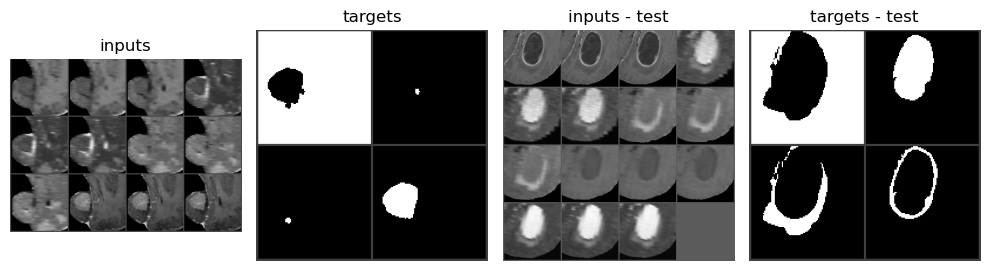

In [5]:
fig = Figure()
fig.add().imshow_batch(dstrain[20][0]).style_img('inputs')
fig.add().imshow_batch(dstrain[20][1]).style_img('targets')
fig.add().imshow_batch(dstest[20][0]).style_img('inputs - test')
fig.add().imshow_batch(dstest[20][1]).style_img('targets - test')
fig.create(1, figsize=(10,10))

# Model

In [6]:
from monai.networks.nets import VNet # type:ignore
print(f"{count_parameters(VNet(2, 16, 4)) = }")

count_parameters(VNet(2, 16, 4)) = 9366348


# Train

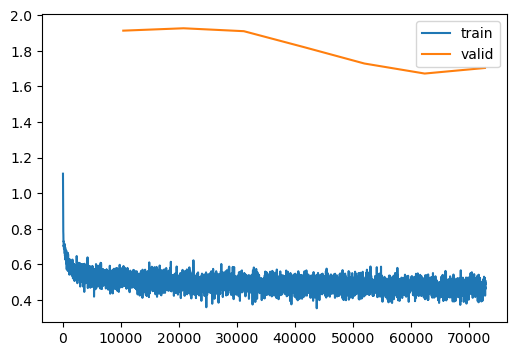

Keyboard interrupt, stopping the training...
time: min: 7.2174; max: 23442.6295; last: 23442.6295
lr: min: 0.0100; max: 0.0100; last: 0.0100
train loss: min: 0.3138; max: 1.1099; last: 0.5314
train accuracy: min: 0.0265; max: 0.9761; last: 0.9379
train iou: min: 0.0582; max: 0.9565; last: 0.9213
train precision: min: 0.0985; max: 0.9757; last: 0.9349
train recall: min: 0.0985; max: 0.9757; last: 0.9349
train f1: min: 0.0985; max: 0.9757; last: 0.9379
train average precision: min: 0.2445; max: 0.5544; last: 0.4306
train roc auc: min: 0.4421; max: 0.8685; last: 0.8171
test loss: min: 1.6726; max: 1.9270; last: 1.7040
test accuracy: min: 0.2947; max: 0.3492; last: 0.3441
test iou: min: 0.2285; max: 0.3019; last: 0.2719
test precision: min: 0.2897; max: 0.3708; last: 0.3317
test recall: min: 0.2897; max: 0.3708; last: 0.3317
test f1: min: 0.2866; max: 0.3530; last: 0.3481
test average precision: min: 0.2561; max: 0.2610; last: 0.2567
test roc auc: min: 0.5042; max: 0.5437; last: 0.5148


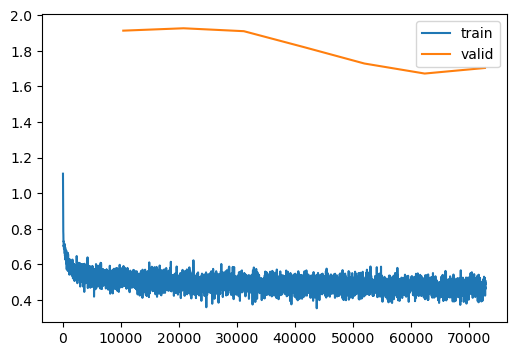

In [7]:
from schedulefree import AdamWScheduleFree
from monai.losses import DiceFocalLoss # type:ignore

MODEL = VNet(2, 16, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 32
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = ConcatZeroChannelsToDataloader(DataLoader(dstrain, BATCH_SIZE, shuffle=True), 16)
dltest = ConcatZeroChannelsToDataloader(DataLoader(dstest, BATCH_SIZE), 16)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), Log_LastGradsAngle(128), Log_GradPath(1)
              #Log_UpdateDist(128), Log_GradDist(128), Log_GradUpdateAngle(128), Log_ParamDist(128),
              #Log_LastUpdatesAngle(128),
              #Log_ParamPath(32), Log_UpdatePath(32),
              Log_Time(), Save_Best(), Save_Last(), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_Precision(4, True, True, step=16),
              Torcheval_Recall(4, True, True, step=16),
              Torcheval_Dice(4, True, True, step=8, name='f1'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              FastProgressBar(step_batch=128, plot=True),
              Summary(),
              PlotSummary(),
              CallTrainAndEvalOnOptimizer(),
              )

LEARNER_NAME = f"bs32 lr{LR:.0e} eps1e-6"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False)
plt.show()